# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 8.51

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [489]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['font.size'] = 14

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [490]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [491]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [492]:
np.unique(y_random) # проверим уникальные значения в предсказании

array([0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: predict_proba возвращает ероятности принадлежности к классу. Так как классификатор случайный, поэтому 0.5

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [493]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


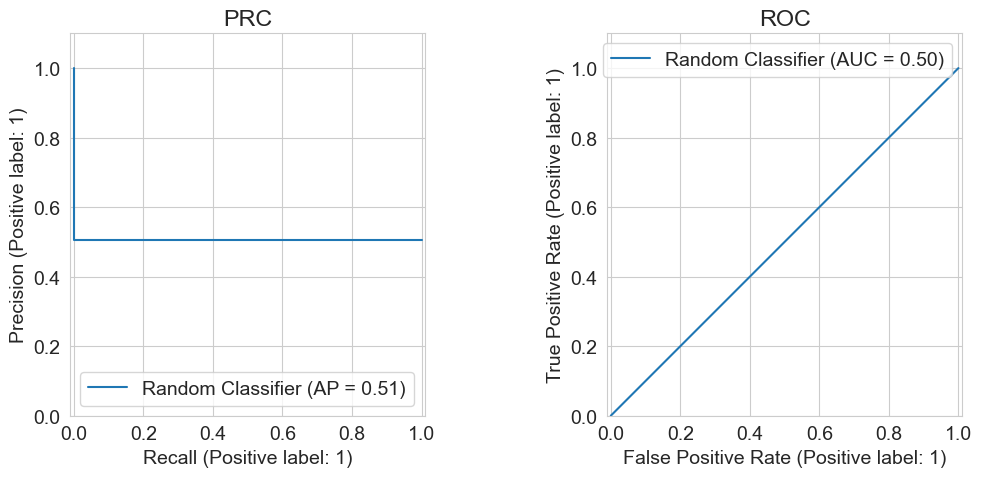

In [494]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [495]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


In [496]:
from sklearn.metrics import auc

def new_metrics(df, y_true, y_pred, classifier_name, reg_const=0):
    pr, rec, _ = precision_recall_curve(y_true, y_pred)
    df_metrics.loc[classifier_name] = [
        auc(rec, pr),
        roc_auc_score(y_true, y_pred),
        reg_const
    ]

    return df_metrics

__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [497]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [498]:
from sklearn.svm import LinearSVC

C_values = np.logspace(-5, 1, 10)
val_score = []

best_C = 0
best_auc_roc = 0

for C in C_values:
    svc = LinearSVC(max_iter=110000, C=C).fit(X_train, y_train)
    y_pred = svc.decision_function(X_val)
    val_score.append(roc_auc_score(y_val, y_pred))
    if val_score[-1] > best_auc_roc:
        best_C = C
        best_auc_roc = val_score[-1]

print(f"Лучший AUC_ROC: {best_auc_roc} c параметром C: {best_C}")

Лучший AUC_ROC: 0.8465575549974527 c параметром C: 0.1


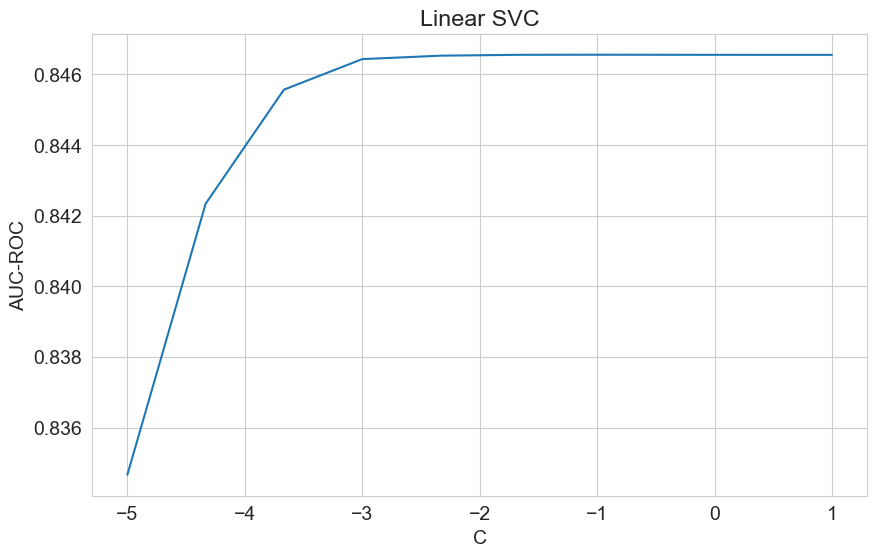

In [499]:
sns.lineplot(x=np.log10(C_values), y=np.array(val_score))
plt.xlabel("C")
plt.ylabel('AUC-ROC')
plt.title("Linear SVC")
plt.show()

In [500]:
svc = LinearSVC(max_iter=110000, C=best_C).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

Linear SVC metrics
AUC-PR: 0.8306
AUC-ROC: 0.8478


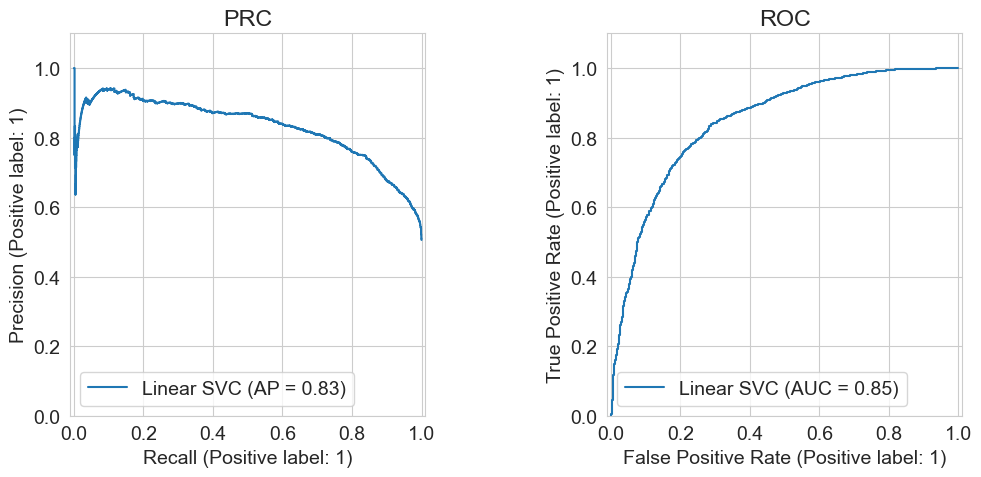

In [501]:
depict_pr_roc(y_test, svc_pred, "Linear SVC")

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [502]:
new_metrics(df_metrics, y_test, svc_pred, "LinearSVC")

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
LinearSVC,0.830350,0.847836,0.0


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [503]:
from sklearn.linear_model import LogisticRegression

C_values = np.logspace(-5, 2, 10)
val_score = []

best_C = 0
best_auc_roc = 0

for C in C_values:
    svc = LogisticRegression(max_iter=110000, C=C).fit(X_train, y_train)
    y_pred = svc.decision_function(X_val)
    val_score.append(roc_auc_score(y_val, y_pred))
    if val_score[-1] > best_auc_roc:
        best_C = C
        best_auc_roc = val_score[-1]

print(f"Лучший AUC_ROC: {best_auc_roc} c параметром C: {best_C}")

Лучший AUC_ROC: 0.8467022009221498 c параметром C: 0.4641588833612782


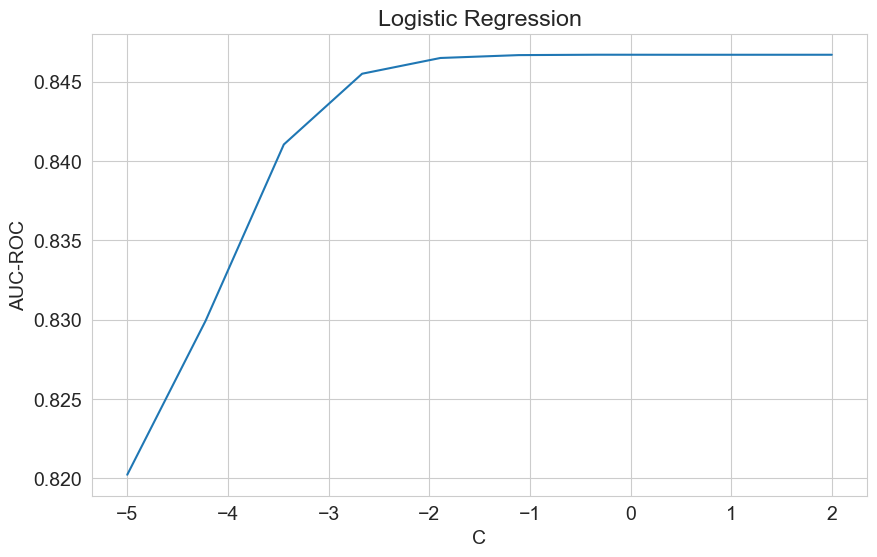

In [504]:
sns.lineplot(x=np.log10(C_values), y=np.array(val_score))
plt.xlabel("C")
plt.ylabel('AUC-ROC')
plt.title("Logistic Regression")
plt.show()

In [505]:
lr = LogisticRegression(max_iter=110000, C=best_C).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)
new_metrics(df_metrics, y_test, lr_pred, "Logistic Regression")

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
LinearSVC,0.830350,0.847836,0.0
Logistic Regression,0.829873,0.847985,0.0


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
Linear SVC metrics
AUC-PR: 0.8306
AUC-ROC: 0.8478
Logistic Regression metrics
AUC-PR: 0.8301
AUC-ROC: 0.8480


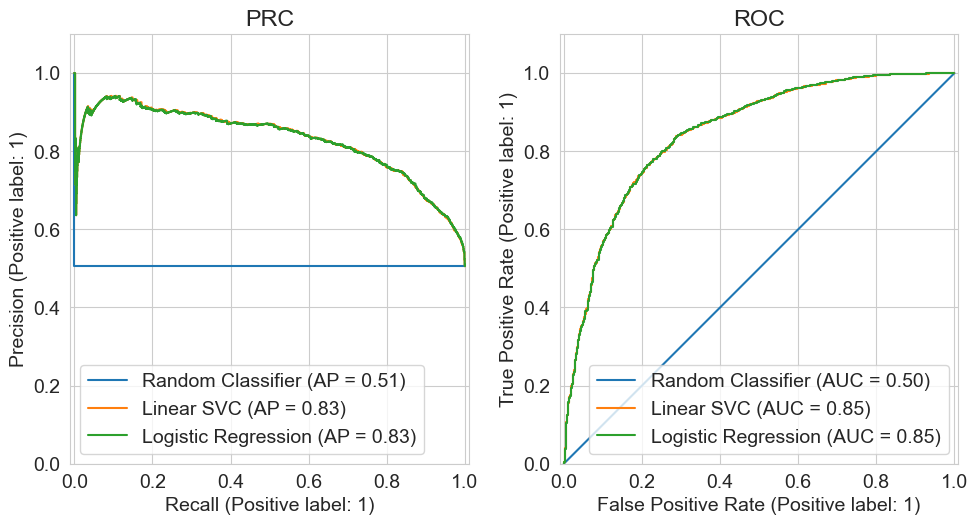

In [506]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

depict_pr_roc(y_test, y_random, 'Random Classifier', ax)
depict_pr_roc(y_test, svc_pred, "Linear SVC", ax)
depict_pr_roc(y_test, lr_pred, "Logistic Regression", ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Различий нет, т.к. в наших данных нет особенностей, которые лучше бы понимались одним или другим алгоритмом

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [507]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=43)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

from sklearn.svm import SVC

svc = SVC(kernel="linear", max_iter=100000, C=0.1).fit(X_train, y_train)
pred_svc = svc.decision_function(X_test)
model = svc

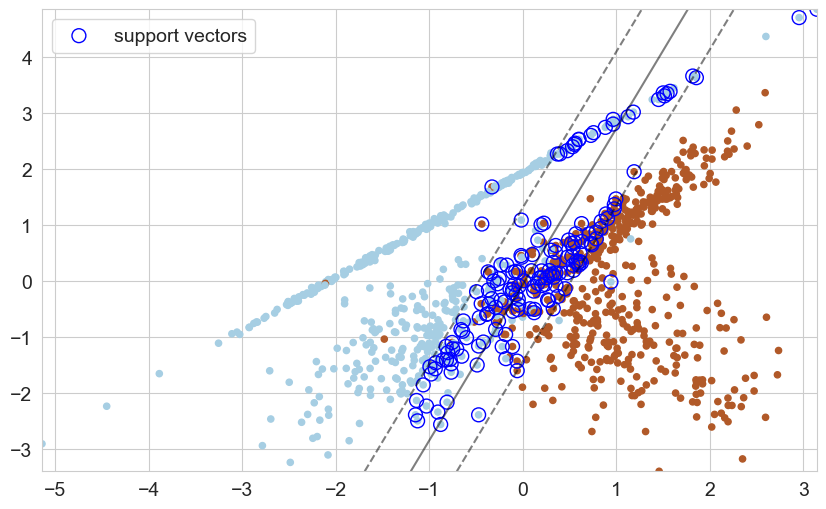

In [508]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape((30, 30))

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(x=X[:, 0],
                y=X[:, 1],
                s=20,
                linewidth=1,
                c=list(y),
                cmap=plt.cm.Paired)

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    label='support vectors',
                    s=100,
                    linewidth=1,
                    edgecolor="blue",
                    facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Опорные объекты - самы близкие к разделяющей плоскости и мисклассификации

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [509]:
lr = LogisticRegression(max_iter=110000, C=0.46).fit(X_train, y_train)
pred_lr = lr.decision_function(X_test)
model = lr

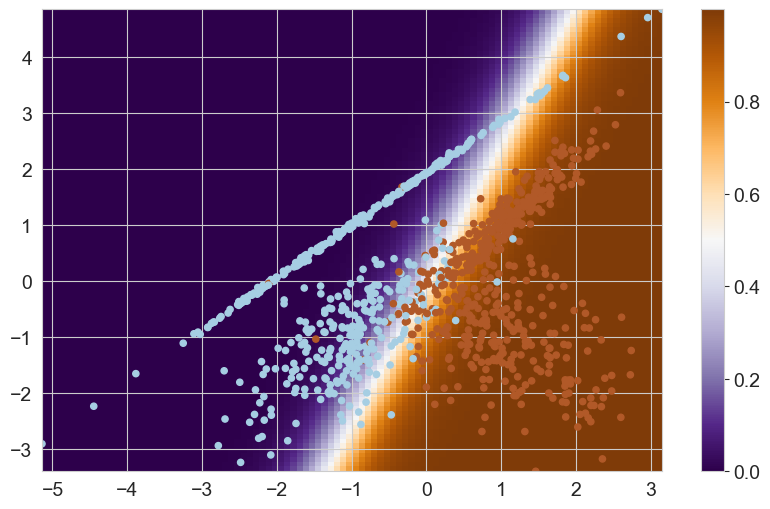

In [510]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1].reshape((100, 100))
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(x=X[:, 0],
                y=X[:, 1],
                s=20,
                linewidth=1,
                c=list(y),
                cmap=plt.cm.Paired)


    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Эта облась - белая полоса и она проходит примерно так же, как и разделяющая гиперплоскость у SVM.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [511]:
def plot_calibration_curve(y_test, preds, title):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.title(title)

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [512]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [513]:
svc = LinearSVC(max_iter=110000, C=0.1).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

lr = LogisticRegression(max_iter=110000, C=0.46).fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

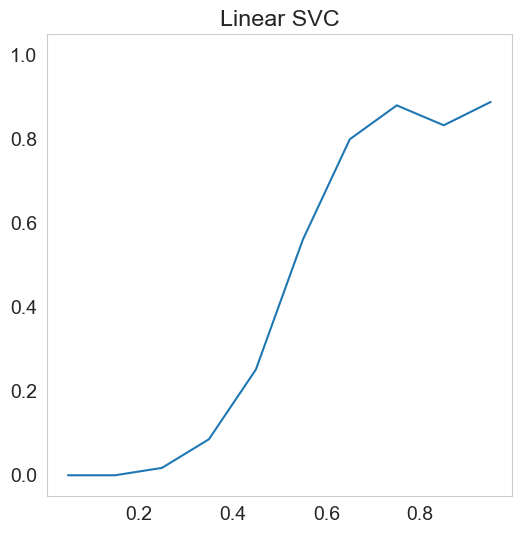

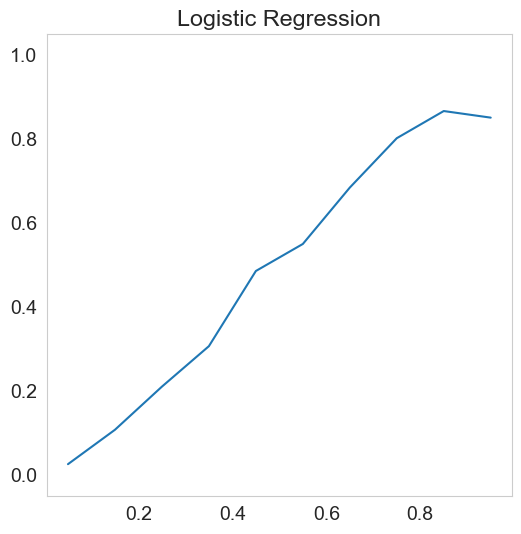

In [514]:
plot_calibration_curve(y_test, svc_pred, "Linear SVC")
plot_calibration_curve(y_test, lr_pred, "Logistic Regression")
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Для логистическое - да, мы ее строили в предпосылке верного предсказания вероятностей (там как раз и было условие, что для фиксированного x мы предсказываем вероятность, равную реальной доли +1). Для SVM - нет, там ничего о корректном предсказании вероятностей не было

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [414]:
# your code here

Изучите распределение ответов классификаторов при помощи гистограмм

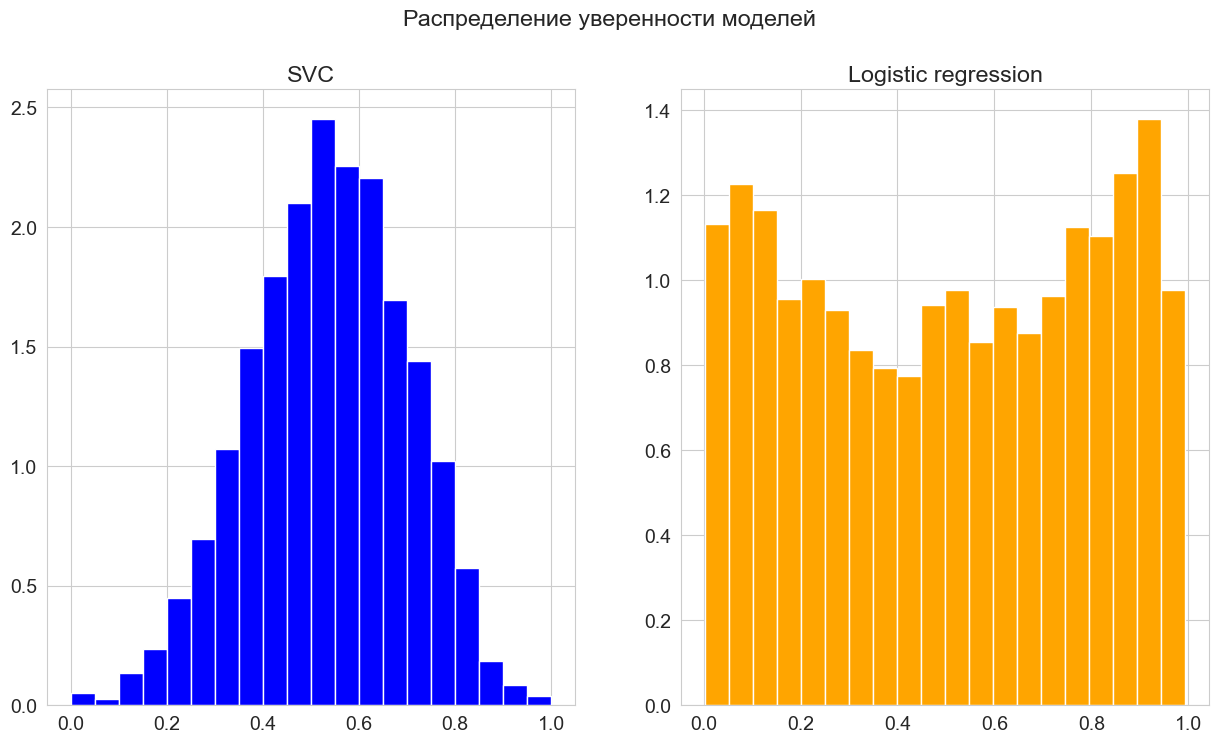

In [515]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Распределение уверенности моделей')
plt.show()

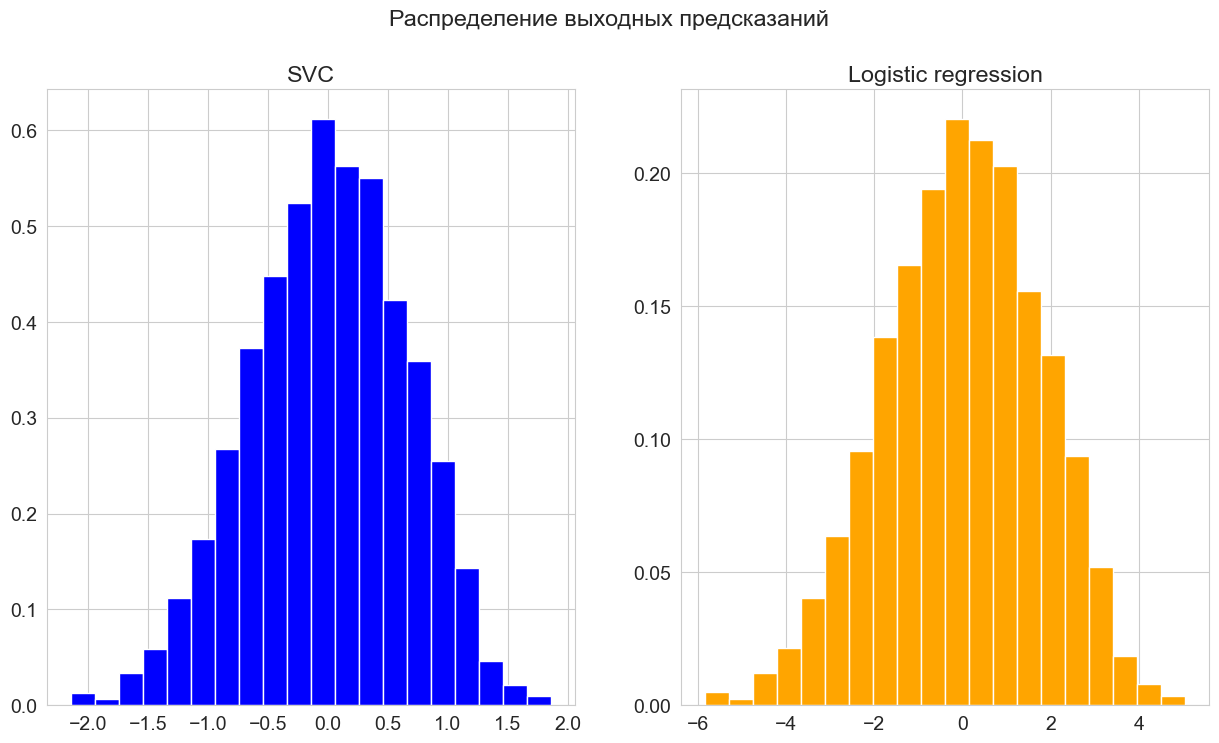

In [516]:
svc_pred = svc.decision_function(X_test)
lr_pred = lr.decision_function(X_test)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Распределение выходных предсказаний')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Обратим внимание, что распределения выходов модели совпадают, то есть предсказания практически одинаковы. Однако сигмоида в логистической регрессии формирует равномерное распределение, из-за чего калибровочная кривая близка к диагонали. В то же время, мин-макс преобразование не изменяет распределение, и оно остается нормальным. Можно заметить, что мы видим лишь один пик, тогда как в хорошей модели их обычно два: один около -x и другой около +x, что отражает уверенность модели в каждом классе. У нас же пик находится в 0, что указывает на частые неуверенные предсказания. Однако это объяснимо, так как, по графикам, видно, что make_classification генерирует перемешанные данные, которые сложно разделить линейно.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [517]:
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(svc, cv=3)
svc_calibrated = calibrator.fit(X_train, y_train)
svc_pred = svc_calibrated.predict_proba(X_test)[:, 1]
lr_pred = lr.predict_proba(X_test)[:, 1]

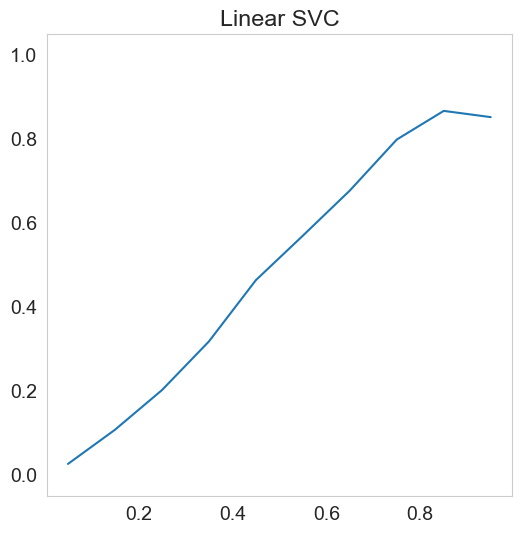

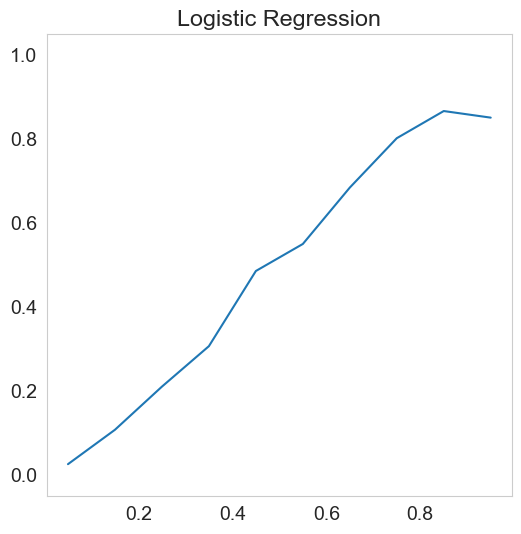

In [518]:
plot_calibration_curve(y_test, svc_pred, "Linear SVC")
plot_calibration_curve(y_test, lr_pred, "Logistic Regression")

plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Да. Если я не ошибаюсь, еще базово стоит метод `sigmoid`, поэтому они теперь идентичны

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [519]:
from scipy.special import expit
def calibrate(y_pred):
    return expit(y_pred)

svc_calibrated_pred = calibrate(svc.decision_function(X_test))
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


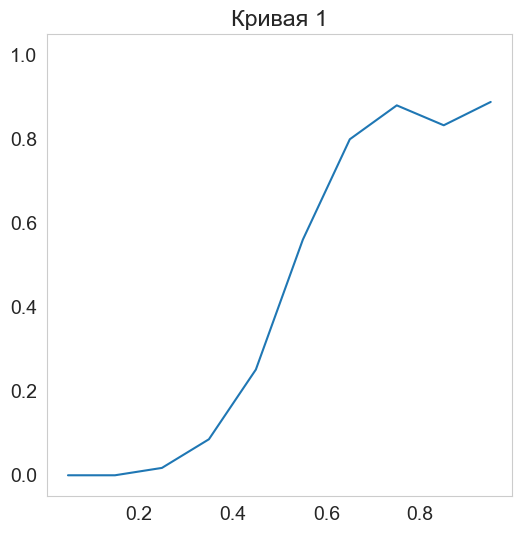

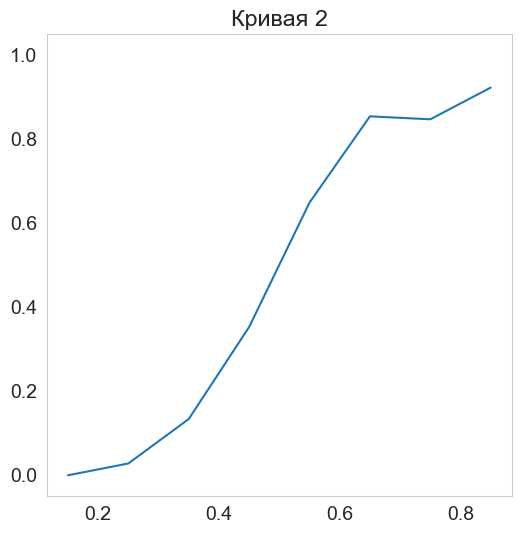

In [520]:
plot_calibration_curve(y_test, svc_pred, "Кривая 1")
plot_calibration_curve(y_test, svc_calibrated_pred, "Кривая 2")
plt.show()

Видно, что этот способ слегка лучше, чем просто мин-макс, а значит модель должна учиться с сигмоидой, либо учить сигмоиду, как это происходит в логистической регрессии или в Platt

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [521]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [522]:
df = pd.read_csv(path)
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [523]:
categorical_columns = ["Marital Status", "Gender", "Education", "Occupation", "Home Owner", "Commute Distance", "Region"]
numerical_columns = ["Income", "Children", "Cars", "Age"]

In [524]:
# Заменим пропуски категориальных переменных
df[categorical_columns] = df[categorical_columns].fillna("undefined")

# Отделим X и y
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

# Разделим на категориальные признаки и числовые
X_numerical = X[numerical_columns]
X_categorical = X[categorical_columns]

В начале поработаем только с категориальными признаками

In [525]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [526]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown="error"), categorical_columns),
])

pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('logistic_regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

AUC-ROC: 0.5925961538461538


In [527]:
%%timeit

column_transformer = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown="error"), categorical_columns),
])

pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('logistic_regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)

2.83 ms ± 179 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Я дважды написал одно и то же в ячейках, чтобы во второй модель не была с предобученными весами

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
%%timeit

from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="error"), categorical_columns),
])

pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('logistic_regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

4.89 ms ± 187 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [529]:
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

AUC-ROC: 0.5925961538461538


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [530]:
def compute_mte_mapping(X, y, features):
    mte_mapping = {}
    for feature in features:
        feature_map = {}
        unique_values = np.unique(X[feature])
        for value in unique_values:
            matching_targets = y[X[feature] == value]
            feature_map[value] = matching_targets.mean()
        mte_mapping[feature] = feature_map
    return mte_mapping

def apply_mte(X, features, mte_mapping):
    X_transformed = X.copy()
    for feature in features:
        X_transformed[feature] = X_transformed[feature].map(mte_mapping[feature])
    return X_transformed

In [531]:
%%timeit

mte_map = compute_mte_mapping(X_train, y_train, categorical_columns)
X_test_mte = apply_mte(X_test, categorical_columns, mte_map)
X_train_mte = apply_mte(X_train, categorical_columns, mte_map)

model = LogisticRegression()
model.fit(X_train_mte, y_train)
y_pred = model.predict_proba(X_test_mte)[:, 1]

7.54 ms ± 94.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [532]:
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

AUC-ROC: 0.5925961538461538


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
# your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [533]:
from sklearn.base import BaseEstimator, TransformerMixin


class NoisyMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features, sigma=1):
        super().__init__()
        self.mte_map = {}
        self.features = features
        self.sigma = sigma

    def fit(self, X, y):
        Xy = pd.concat((X, pd.DataFrame(y)), axis=1).rename(columns={y.name : "target"})
        for feature in self.features:
            self.mte_map[feature] = Xy.groupby(feature)["target"].mean()
            self.mte_map[feature] += np.random.randn(self.mte_map[feature].shape[0]) * self.sigma
        return self


    def transform(self, X):
        X_mte = X.copy()
        for feature in self.features:
            X_mte[feature] = X_mte[feature].map(self.mte_map[feature])
        return X_mte

In [534]:
column_transformer = ColumnTransformer([
    ('mte', NoisyMeanTargetEncoder(categorical_columns), categorical_columns),
])

pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('logistic_regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

AUC-ROC: 0.5220192307692308


In [535]:
for sigma in np.logspace(-4, 1, 10):
    column_transformer = ColumnTransformer([
        ('mte', NoisyMeanTargetEncoder(categorical_columns, sigma), categorical_columns),
    ])

    pipeline = Pipeline(steps=[
        ('transformer', column_transformer),
        ('logistic_regression', LogisticRegression())
    ])

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}, sigma: {sigma}")

AUC-ROC: 0.6631730769230769, sigma: 0.0001
AUC-ROC: 0.6636217948717948, sigma: 0.00035938136638046257
AUC-ROC: 0.6634294871794872, sigma: 0.001291549665014884
AUC-ROC: 0.662147435897436, sigma: 0.004641588833612782
AUC-ROC: 0.6474679487179489, sigma: 0.016681005372000592
AUC-ROC: 0.6106730769230769, sigma: 0.05994842503189409
AUC-ROC: 0.5442628205128205, sigma: 0.21544346900318845
AUC-ROC: 0.5638141025641026, sigma: 0.7742636826811278
AUC-ROC: 0.5656089743589743, sigma: 2.782559402207126
AUC-ROC: 0.5703525641025641, sigma: 10.0


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Да, немного помогло, потому что переобучение стало ниже

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global\_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global\_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [536]:
class SmoothMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features, C=10):
        super().__init__()
        self.mte_map = {}
        self.features = features
        self.C = C

    def fit(self, X, y):
        Xy = pd.concat((X, pd.DataFrame(y)), axis=1).rename(columns={y.name : "target"})
        self.global_mean = np.mean(y)
        for feature in self.features:
            pos = Xy.groupby(feature)["target"].sum() + self.C * self.global_mean
            total = Xy.groupby(feature)["target"].count() + self.C
            self.mte_map[feature] = pos * 1.0 / total
        return self


    def transform(self, X):
        X_mte = X.copy()
        for feature in self.features:
            X_mte[feature] = X_mte[feature].map(self.mte_map[feature])
            X_mte[feature] = X_mte[feature].fillna(self.global_mean)
        return X_mte

In [537]:
column_transformer = ColumnTransformer([
    ('mte', SmoothMeanTargetEncoder(categorical_columns), categorical_columns),
])

pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('logistic_regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

AUC-ROC: 0.6625320512820513


In [538]:
for C in np.linspace(-100, 100, 10):
    column_transformer = ColumnTransformer([
        ('mte', SmoothMeanTargetEncoder(categorical_columns, C), categorical_columns),
    ])

    pipeline = Pipeline(steps=[
        ('transformer', column_transformer),
        ('logistic_regression', LogisticRegression())
    ])

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}, C: {C}")

AUC-ROC: 0.547147435897436, C: -100.0
AUC-ROC: 0.59125, C: -77.77777777777777
AUC-ROC: 0.6787500000000001, C: -55.55555555555556
AUC-ROC: 0.6904807692307693, C: -33.33333333333334
AUC-ROC: 0.6951602564102565, C: -11.111111111111114
AUC-ROC: 0.6626602564102564, C: 11.111111111111114
AUC-ROC: 0.6556730769230769, C: 33.333333333333314
AUC-ROC: 0.6485576923076923, C: 55.55555555555554
AUC-ROC: 0.6440064102564104, C: 77.77777777777777
AUC-ROC: 0.6389423076923078, C: 100.0


Лучший результат был показан на значении -11

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [539]:
X[numerical_columns] = X[numerical_columns].fillna(X[numerical_columns].mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43, stratify=y)

In [540]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    1000 non-null   object 
 2   Gender            1000 non-null   object 
 3   Income            1000 non-null   float64
 4   Children          1000 non-null   float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        1000 non-null   object 
 8   Cars              1000 non-null   float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               1000 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 93.9+ KB


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [541]:
for feature in numerical_columns:
    print(feature, len(np.unique(X[feature])))
print(np.min(X[numerical_columns], axis=0))

Income 17
Children 7
Cars 6
Age 54
Income      10000.0
Children        0.0
Cars            0.0
Age            25.0
dtype: float64


In [542]:
from sklearn.preprocessing import StandardScaler
def test_features_mte(X_train, X_test, y_train, y_test, numerical_columns=[], categorical_columns=[]):
    column_transformer = ColumnTransformer([
        ('mte', SmoothMeanTargetEncoder(categorical_columns, 10), categorical_columns),
        ('scaler', StandardScaler(), numerical_columns)
    ])

    pipeline = Pipeline(steps=[
        ('transformer', column_transformer),
        ('logistic_regression', LogisticRegression())
    ])

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

In [543]:
print("All 4 numerical")
test_features_mte(X_train, X_test, y_train, y_test,
              numerical_columns=["Income", "Children", "Cars", "Age"],
              categorical_columns=(categorical_columns)
              )

for feature in numerical_columns:
    print()
    print(f"{feature} - categorical")
    numerical_copy = numerical_columns.copy()
    numerical_copy.remove(feature)
    test_features_mte(X_train, X_test, y_train, y_test,
                numerical_columns=numerical_copy,
                categorical_columns=(categorical_columns + [feature])
                )
    
print("\nAll 4 categorical")
test_features_mte(X_train, X_test, y_train, y_test,
              numerical_columns=[],
              categorical_columns=(categorical_columns + ["Income", "Children", "Cars", "Age"])
              )


All 4 numerical
AUC-ROC: 0.7444230769230769

Income - categorical
AUC-ROC: 0.7275

Children - categorical
AUC-ROC: 0.7457692307692307

Cars - categorical
AUC-ROC: 0.725

Age - categorical
AUC-ROC: 0.7101923076923077

All 4 categorical
AUC-ROC: 0.689551282051282


In [544]:
from sklearn.preprocessing import OneHotEncoder

def test_features_ohe(X_train, X_test, y_train, y_test, numerical_columns=[], categorical_columns=[]):
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(), categorical_columns),
        ('scaler', StandardScaler(), numerical_columns)
    ])

    pipeline = Pipeline(steps=[
        ('transformer', column_transformer),
        ('logistic_regression', LogisticRegression())
    ])

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

In [545]:
print("All 4 numerical")
test_features_ohe(X_train, X_test, y_train, y_test,
              numerical_columns=["Income", "Children", "Cars", "Age"],
              categorical_columns=(categorical_columns)
              )

All 4 numerical
AUC-ROC: 0.7155128205128204


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ # your answer here

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [546]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-12-02 23:32:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data.2»

adult.data.2            [              <=>   ]   3,79M   935KB/s    за 4,3s    

2024-12-02 23:32:44 (893 KB/s) - «adult.data.2» сохранён [3974305]



In [547]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
16621,53,Federal-gov,105788,Bachelors,13,Divorced,Exec-managerial,Unmarried,Black,Female,0,0,50,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [548]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df['income'], train_size=0.75, random_state=777, stratify=df["income"])

In [549]:
X_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
14004,60,State-gov,194252,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,3103,0,40,United-States
21060,41,Local-gov,26669,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
7926,18,Private,165754,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,30,United-States
11552,61,Local-gov,115023,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States
15648,26,Self-emp-not-inc,93806,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,55,United-States


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [550]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_features = [
    'workclass', 'education', 'marital-status', 
    'occupation', 'relationship', 'race', 
    'sex', 'native-country'
]
numeric_features = [
    'age', 'fnlwgt', 'education-num', 
    'capital-gain', 'capital-loss', 'hours-per-week'
]

column_transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('passthrough', numeric_features)
)

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

additional_columns = X_train_transformed.shape[1] - X_train.shape[1]
print(additional_columns)

94


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [551]:
model = LogisticRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict_proba(X_test_transformed)[:, 1]
print(f"auc_pr = {average_precision_score(y_test, y_pred)}")

auc_pr = 0.45599737279715097


/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [552]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=777)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [554]:
from time import time

start = time()

transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('numeric', 'passthrough', numeric_features)
])

X_train_encoded = transformer.fit_transform(X_train)
X_val_encoded = transformer.transform(X_val)

features = sorted(
    [(abs(coef), feature) for coef, feature in zip(model.coef_[0], transformer.get_feature_names_out())],
    key=lambda x: -x[0]
)[:40]
selected_features = [feature for _, feature in features]

selected_indexes = [
    i for i, name in enumerate(transformer.get_feature_names_out())
    if name in selected_features
]

X_train_selected = X_train_encoded.toarray()[:, selected_indexes]
X_val_selected = X_val_encoded.toarray()[:, selected_indexes]

logreg = LogisticRegression()
logreg.fit(X_train_selected, y_train)
predictions = logreg.predict_proba(X_val_selected)[:, 1]

print(f"auc_pr = {average_precision_score(y_val, predictions)}")
print(f"time = {time() - start}")

auc_pr = 0.678983399050725
time = 0.10165095329284668


/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Изменилось ли качество? Как?

Да, качество улучшилось

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [555]:
from sklearn.preprocessing import StandardScaler
from time import time

start = time()

transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

X_train_transformed = transformer.fit_transform(X_train)
X_val_transformed = transformer.transform(X_val)
X_test_transformed = transformer.transform(X_test)

model.fit(X_train_transformed, y_train)

features = sorted(
    [(abs(coef), feature) for coef, feature in zip(model.coef_[0], transformer.get_feature_names_out())],
    key=lambda x: -x[0]
)[:40]
selected_features = [feature for _, feature in features]

print("\n".join(selected_features))

selected_indexes = [
    i for i, name in enumerate(transformer.get_feature_names_out())
    if name in selected_features
]

X_train_selected = X_train_transformed.toarray()[:, selected_indexes]
X_val_selected = X_val_transformed.toarray()[:, selected_indexes]

logreg = LogisticRegression()
logreg.fit(X_train_selected, y_train)
predictions = logreg.predict_proba(X_val_selected)[:, 1]

print(f"auc_pr = {average_precision_score(y_val, predictions)}")
print(f"time = {time() - start}")

scaler__capital-gain
ohe__marital-status_ Married-AF-spouse
ohe__native-country_ Columbia
ohe__occupation_ Priv-house-serv
ohe__marital-status_ Never-married
ohe__relationship_ Wife
ohe__marital-status_ Married-civ-spouse
ohe__occupation_ Farming-fishing
ohe__marital-status_ Separated
ohe__relationship_ Own-child
ohe__native-country_ Germany
ohe__sex_ Female
ohe__occupation_ Exec-managerial
ohe__native-country_ Philippines
ohe__native-country_ Ecuador
ohe__relationship_ Other-relative
ohe__native-country_ Dominican-Republic
ohe__native-country_ Canada
ohe__native-country_ Italy
ohe__occupation_ Other-service
ohe__education_ Preschool
scaler__education-num
ohe__native-country_ Cambodia
ohe__occupation_ Protective-serv
ohe__marital-status_ Divorced
ohe__native-country_ Vietnam
ohe__occupation_ Tech-support
ohe__marital-status_ Married-spouse-absent
ohe__education_ 5th-6th
ohe__occupation_ Prof-specialty
ohe__workclass_ Without-pay
ohe__workclass_ Federal-gov
ohe__native-country_ Cuba
ohe

Качество стало ещё заметно лучше

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [556]:
from sklearn.preprocessing import StandardScaler
from time import time

start_time = time()

transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('numeric', 'passthrough', numeric_features)
])

scaler = StandardScaler(with_mean=False)

X_train_encoded = transformer.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_encoded)

X_val_encoded = transformer.transform(X_val)
X_val_scaled = scaler.transform(X_val_encoded)

X_test_encoded = transformer.transform(X_test)
X_test_scaled = scaler.transform(X_test_encoded)

model.fit(X_train_scaled, y_train)

features = sorted(
    [(abs(coef), feature) for coef, feature in zip(model.coef_[0], transformer.get_feature_names_out())],
    key=lambda x: -x[0]
)[:40]
top_features = [feature for _, feature in features]

print("\n".join(top_features))

selected_indexes = [
    i for i, name in enumerate(transformer.get_feature_names_out())
    if name in top_features
]

X_train_selected = X_train_scaled.toarray()[:, selected_indexes]
X_val_selected = X_val_scaled.toarray()[:, selected_indexes]

logistic_model = LogisticRegression()
logistic_model.fit(X_train_selected, y_train)
predicted_probs = logistic_model.predict_proba(X_val_selected)[:, 1]

print(f"auc_pr = {average_precision_score(y_val, predicted_probs)}")
print(f"time = {time() - start_time}")

numeric__capital-gain
ohe__education_ Preschool
ohe__marital-status_ Never-married
ohe__marital-status_ Married-civ-spouse
ohe__sex_ Female
ohe__relationship_ Own-child
numeric__hours-per-week
ohe__occupation_ Priv-house-serv
ohe__race_ Black
ohe__native-country_ United-States
ohe__occupation_ Other-service
numeric__age
ohe__marital-status_ Divorced
ohe__education_ HS-grad
ohe__education_ 7th-8th
ohe__race_ White
numeric__capital-loss
ohe__education_ 11th
ohe__education_ 10th
ohe__education_ Masters
ohe__native-country_ Mexico
ohe__education_ Bachelors
ohe__occupation_ Farming-fishing
ohe__workclass_ Self-emp-not-inc
ohe__education_ Doctorate
ohe__marital-status_ Separated
ohe__education_ 9th
ohe__relationship_ Husband
ohe__education_ Prof-school
ohe__workclass_ Private
ohe__relationship_ Wife
ohe__education_ 1st-4th
ohe__education_ 5th-6th
ohe__native-country_ ?
ohe__race_ Asian-Pac-Islander
ohe__occupation_ Handlers-cleaners
ohe__native-country_ Columbia
ohe__occupation_ Exec-manager

/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** # your code here

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [558]:
import time

t1 = time.time()

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('numeric', "passthrough", numeric_features)

])
ss = StandardScaler(with_mean=False)

X_train_m = column_transformer.fit_transform(X_train)
X_train_m = ss.fit_transform(X_train_m)
X_val_m = column_transformer.transform(X_val)
X_val_m = ss.transform(X_val_m)
X_test_m = column_transformer.transform(X_test)
X_test_m = ss.transform(X_test_m)

е1 = time.time()
corr = pd.DataFrame(X_train_m.toarray()).corrwith(y_train)

ind = corr.abs().nlargest(40).index
X_train_m = X_train_m[:, ind]
X_val_m = X_val_m[:, ind]

model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_val_m)[:, 1]
print(f"auc_pr = {average_precision_score(y_val, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.6667993082521533
time = 0.25650811195373535


/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [559]:
target = "Purchased Bike"

t1 = time.time()
X_train_m = X_train.copy()

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('numeric', "passthrough", numeric_features)
])
ss = StandardScaler(with_mean=False)

X_train_m = column_transformer.fit_transform(X_train)
X_train_m = ss.fit_transform(X_train_m)
X_val_m = column_transformer.transform(X_val)
X_val_m = ss.transform(X_val_m)
X_test_m = column_transformer.transform(X_test)
X_test_m = ss.transform(X_test_m)

X_train_m = pd.DataFrame(X_train_m.toarray(), columns=column_transformer.get_feature_names_out())
X_val_m = pd.DataFrame(X_val_m.toarray(), columns=column_transformer.get_feature_names_out())

X_train_m[target] = y_train

ts = []
for feature in X_train_m.columns[:-1]:
    stat = X_train_m.groupby(target)[feature].agg(['mean', 'count', 'std'])
    top = np.abs(stat['mean'][1] - stat['mean'][0])
    bottom_top = (stat['count'][1] * stat['std'][1] ** 2 + stat['count'][0] * stat['std'][0] ** 2)
    bottom_bottom = stat['count'][0] + stat['count'][1]
    ts.append(top / np.sqrt(bottom_top / bottom_bottom))

X_train_m.drop(target, axis=1, inplace=True)
coefs = pd.DataFrame({'ts' : ts, 'name' : column_transformer.get_feature_names_out()})

X_train_m = X_train_m[coefs.sort_values('ts', ascending=False).iloc[:40, :]['name']]
X_val_m = X_val_m[coefs.sort_values('ts', ascending=False).iloc[:40, :]['name']]

model.fit(X_train_m, y_train)
y_pred = model.predict_proba(X_val_m)[:, 1]

print(f"auc_pr = {average_precision_score(y_val, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.6667774869745879
time = 0.19997477531433105


/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [560]:
t1 = time.time()

k, m = 50, 3

X_train_m = X_train.copy()
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('numeric', "passthrough", numeric_features)
])
ss = StandardScaler(with_mean=False)

X_train_m = column_transformer.fit_transform(X_train)
X_train_m = ss.fit_transform(X_train_m)
X_val_m = column_transformer.transform(X_val)
X_val_m = ss.transform(X_val_m)
X_test_m = column_transformer.transform(X_test)
X_test_m = ss.transform(X_test_m)

X_train_m = pd.DataFrame(X_train_m.toarray(), columns=column_transformer.get_feature_names_out())
X_val_m = pd.DataFrame(X_val_m.toarray(), columns=column_transformer.get_feature_names_out())

arr = X_train_m.columns
while arr.shape[0] > k:
    model.fit(X_train_m, y_train)
    coefs = pd.DataFrame({'x' : np.abs(model.coef_.reshape(-1, )), 'name' : arr})
    dropped = coefs.sort_values('x')['name'].iloc[:min(arr.shape[0] - k, m)]
    X_train_m.drop(dropped, axis=1, inplace=True)
    arr = X_train_m.columns


model.fit(X_train_m, y_train)
X_val_m = X_val_m[X_train_m.columns]
y_pred = model.predict_proba(X_val_m)[:, 1]
print(f"auc_pr = {average_precision_score(y_val, y_pred)}")
print(f"time = {time.time() - t1}")

auc_pr = 0.7590453695200876
time = 1.2009949684143066


/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [561]:
t1 = time.time()

k, m = 50, 3

X_train_m = X_train.copy()
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('numeric', "passthrough", numeric_features)
])
ss = StandardScaler(with_mean=False)

X_train_m = column_transformer.fit_transform(X_train)
X_train_m = ss.fit_transform(X_train_m)
X_val_m = column_transformer.transform(X_val)
X_val_m = ss.transform(X_val_m)
X_test_m = column_transformer.transform(X_test)
X_test_m = ss.transform(X_test_m)

X_train_m = pd.DataFrame(X_train_m.toarray(), columns=column_transformer.get_feature_names_out())
X_val_m = pd.DataFrame(X_val_m.toarray(), columns=column_transformer.get_feature_names_out())

X_train_m_tmp = X_train_m.copy()
columns_to_take = []

while len(columns_to_take) < k:
    model.fit(X_train_m_tmp, y_train)
    coefs = pd.DataFrame({'x' : np.abs(model.coef_.reshape(-1, )), 'name' : X_train_m_tmp.columns})
    taken = coefs.sort_values('x', ascending=False)['name'].iloc[:min(k - len(columns_to_take), m)]
    X_train_m_tmp.drop(taken, axis=1, inplace=True)
    columns_to_take.extend(taken)

X_train_m = X_train_m[columns_to_take]
X_val_m = X_val_m[columns_to_take]

model.fit(X_train_m, y_train)
X_val_m = X_val_m[X_train_m.columns]
y_pred = model.predict_proba(X_val_m)[:, 1]
print(f"auc_pr = {average_precision_score(y_val, y_pred)}")
print(f"time = {time.time() - t1}")

/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

auc_pr = 0.7583802602758773
time = 0.8033080101013184


/Users/opyat-ne-zavoditsya/hse/code/pr/ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Встроенные методы обладают достаточно хорошей скоростью вычислений и вместе со стандартизацией дают возможность получить высокое качество. Пожалуй это - лучший вариант. Методы фильтрации обладают понятной интерпретацией и имеют высокую скорость работы, но, однако, не учитывают взаимосвязь признаков между собой, поэтому результат - плохое качество. Методы обёртки обладают самым большим временем работы, тем не менее выдают наибольшее качество!

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
df.head()

In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [ ]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            # "metric_key": metric_value
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [ ]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [ ]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [ ]:
# your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [ ]:
# your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
# your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [ ]:
# your code here

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [ ]:
# your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [ ]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Кашенька
